# Mounting and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/capra_lab/HuSC

/content/drive/MyDrive/capra_lab/HuSC


In [ ]:
!uv pip install biopython

Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 95ms
Prepared 1 package in 96ms
Installed 1 package in 17ms
 + biopython==1.86


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from Bio import SeqIO
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import EsmForMaskedLM, EsmTokenizer
from peft import LoraConfig, get_peft_model

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Paths and config

In [ ]:
# Paths
HuSC_DIR = 'HuSC_8'
UNIPROT_FASTA = 'UniProt_Sequences.fasta'
FILTERED_LIST = "conserved_husc_files.txt"

# Model configuration
MODEL_NAME = "facebook/esm2_t30_150M_UR50D"
MAX_LENGTH = 1024

# Training hyperparameters
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3
THRESHOLD = 0
NUM_SAMPLES = 20

# LoRA configuration
LORA_R = 8
LORA_ALPHA = 64
LORA_DROPOUT = 0.1

# Amino acids list
AMINO_ACIDS = ['L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D',
               'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C']

# Loading model and data

In [ ]:
#@title Loss function
def listwise_ranking_loss(predicts, targets):
    """
    ListMLE loss for ranking tasks.

    Args:
        predicts: Predicted scores
        targets: Target scores

    Returns:
        Mean loss value
    """
    indices = targets.sort(descending=True, dim=-1).indices
    predicts = torch.gather(predicts, dim=1, index=indices)

    cumsums = predicts.exp().flip(dims=[1]).cumsum(dim=1).flip(dims=[1])
    loss = torch.log(cumsums + 1e-10) - predicts

    return loss.mean()

In [ ]:
#@title Load ESM2 model with LoRA and tokenizer
print(f"Loading model: {MODEL_NAME}")
model = EsmForMaskedLM.from_pretrained(MODEL_NAME)
tokenizer = EsmTokenizer.from_pretrained(MODEL_NAME)

# Define LoRA target modules
target_modules = [
    "query",
    "key",
    "value",
    "output.dense",
]

# Configure LoRA
lora_config = LoraConfig(
    task_type="FEATURE_EXTRACTION",
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=target_modules,
    lora_dropout=LORA_DROPOUT,
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Freeze all parameters except LoRA
for name, param in model.named_parameters():
    param.requires_grad = False
    if 'lora' in name:
        param.requires_grad = True

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} "
      f"({100 * trainable_params / total_params:.2f}%)")

# Move model to device
model.to(device)

Loading model: facebook/esm2_t30_150M_UR50D


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/520 [00:00<?, ?it/s]

EsmForMaskedLM LOAD REPORT from: facebook/esm2_t30_150M_UR50D
Key                         | Status     |  | 
----------------------------+------------+--+-
esm.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Trainable parameters: 1,996,800 / 150,136,954 (1.33%)


PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): EsmForMaskedLM(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 640, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-29): 30 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=640, out_features=640, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=640, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=640, bias=False)
             

In [ ]:
#@title Dataset class
class ProteinDataset(Dataset):
    """Dataset for protein sequences with HuSC scores."""

    def __init__(self, filelist, tokenizer, fasta_file, max_length=1024):
        self.filelist = filelist
        self.tokenizer = tokenizer
        self.fasta_dict = self._parse_fasta(fasta_file)
        self.max_length = max_length

    def _parse_fasta(self, fasta_file):
        """Parse FASTA file into dictionary."""
        fasta_dict = {}
        for record in SeqIO.parse(fasta_file, "fasta"):
            fasta_dict[record.id] = str(record.seq)
        return fasta_dict

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        file_path = self.filelist[idx]
        file_name = os.path.basename(file_path)
        df = pd.read_csv(file_path, sep='\t')

        # Extract UniProt ID
        key = file_name.split('_')[0]
        sequence = self.fasta_dict.get(key, None)

        if sequence is None:
            print(f'{file_name} not found in FASTA')
            return None

        # Tokenize sequence
        tokenized = self.tokenizer(
            sequence,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze(0)
        attention_mask = tokenized['attention_mask'].squeeze(0)

        # Extract HuSC scores and positions
        husc_scores = torch.tensor(df['HuSC'].values, dtype=torch.float32)
        uniprot_pos = torch.tensor(df['uniprot_pos'].values, dtype=torch.long)

        # Create padded scores tensor
        padded_scores = torch.full((self.max_length - 2, 1), float('nan'))
        for idx, pos in enumerate(uniprot_pos):
            if 0 < pos <= self.max_length - 2:
                padded_scores[pos - 1] = husc_scores[idx]

        return input_ids, attention_mask, padded_scores, file_name, sequence, husc_scores

In [ ]:
#@title split filtered files into training and test sets
with open(FILTERED_LIST, "r") as f:
    base_filenames = [
        line.strip()
        for line in f
        if line.strip()
    ]

# Reconstruct full paths in HuSC_8 dir
filtered_files = [
    os.path.join(HuSC_DIR, fname)
    for fname in base_filenames
]

# Optional sanity check
filtered_files = [f for f in filtered_files if os.path.exists(f)]

print(f"Total filtered files loaded: {len(filtered_files)}")


train_files, val_files = train_test_split(
    filtered_files,
    test_size=0.25,
    random_state=42
)

print(f"Training set size: {len(train_files)}")
print(f"Validation set size: {len(val_files)}")


Total filtered files loaded: 3014
Training set size: 2260
Validation set size: 754


In [ ]:
#@title Create datasets
train_dataset = ProteinDataset(train_files, tokenizer, UNIPROT_FASTA)
val_dataset = ProteinDataset(val_files, tokenizer, UNIPROT_FASTA)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Data loaded successfully!')
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Data loaded successfully!
Training batches: 2260
Validation batches: 754


In [ ]:
#@title process model predictions and compute loss
def process_batch(input_ids, attention_mask, scores, model, device, sequence, husc_scores):
    """
    Process a single batch and compute loss.

    Args:
        input_ids: Tokenized sequence IDs
        attention_mask: Attention mask for the sequence
        scores: Padded HuSC scores tensor
        model: The ESM model
        device: Device to run computation on
        sequence: Original protein sequence
        husc_scores: Raw HuSC scores for the protein

    Returns:
        loss: Computed loss value
        sampled_output: Model predictions
        sampled_target: Target HuSC scores
    """
    scores = scores.to(device).squeeze()
    husc_scores = husc_scores.to(device).squeeze()

    # Identify non-NaN positions
    nan_mask = torch.isnan(scores).squeeze()
    non_nan_mask = ~nan_mask
    masked_target_scores = scores[non_nan_mask]

    # Filter by threshold (HuSC < 0 indicates deleterious variants)
    filtered_indices = torch.nonzero(masked_target_scores < THRESHOLD, as_tuple=True)[0]
    filtered_target = masked_target_scores[filtered_indices]

    # Skip if insufficient data
    if filtered_target.size(0) == 0:
        return torch.tensor(float('nan')), None, None

    # Move inputs to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Forward pass
    results = model(input_ids, attention_mask=attention_mask)
    logits = results.logits

    # Compute log softmax and extract amino acid logits
    log_softmax_results = torch.log_softmax(logits, dim=-1)
    WTlogits = log_softmax_results[:, 1:-1, 4:24]  # Remove special tokens, select AA range

    # Build alphabet mapping (token_string -> index in AA range)
    # tokenizer.get_vocab() returns {token_string: token_id}
    tokenizer_vocab = tokenizer.get_vocab()
    alphabet_dict = {
        token: token_id - 4  # Map token string to index (0-19 for AA tokens)
        for token, token_id in tokenizer_vocab.items()
        if 4 <= token_id <= 23  # Filter for amino acid tokens only
    }

    # Compute normalization tensor
    batch_size, num_residues, _ = WTlogits.size()
    wt_norm_tensors = []

    for batch in range(batch_size):
        batch_seq = sequence[batch]
        seq_indices = [
            alphabet_dict.get(char, 0)
            for char in batch_seq[:num_residues]
        ]

        # Pad if necessary
        if len(seq_indices) < num_residues:
            seq_indices.extend([0] * (num_residues - len(seq_indices)))

        aa_indices = torch.tensor(seq_indices[:num_residues], device=device)
        residue_indices = torch.arange(num_residues, device=device)
        wt_norm_tensor = WTlogits[batch, residue_indices, aa_indices]
        wt_norm_tensors.append(wt_norm_tensor)

    wt_norm_tensor = torch.stack(wt_norm_tensors, dim=0)

    # Compute log-likelihood ratios (LLR)
    LLR_tensor = WTlogits - wt_norm_tensor.unsqueeze(2)

    # Compute entropy-based conservation scores
    probs = F.softmax(LLR_tensor, dim=2)
    entropy_tensor = -torch.sum(probs * torch.log2(probs + 1e-10), dim=2)
    max_entropy = torch.log2(torch.tensor(20.0))
    normalized_entropy = entropy_tensor / max_entropy

    model_scores = normalized_entropy.squeeze()

    # Apply masks to get scores at positions with HuSC annotations
    masked_output = model_scores[non_nan_mask]
    filtered_output = masked_output[filtered_indices]

    # Sample for loss computation
    num_samples = min(NUM_SAMPLES, filtered_target.size(0))
    random_indices = torch.randperm(filtered_target.size(0))[:num_samples]
    sampled_output = filtered_output[random_indices]
    sampled_target = filtered_target[random_indices]

    # Compute listwise ranking loss
    loss = listwise_ranking_loss(sampled_output.unsqueeze(0), sampled_target.unsqueeze(0))

    return loss, sampled_output, sampled_target

# Training

In [ ]:
#@title Training loop
# Initialize optimizer
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

# Tracking variables
validation_losses = []
training_losses = []  # Track training loss at validation intervals
batch_count = 0
early_stop = False

# Early stopping parameters
best_val_loss = float('inf')
patience = 2
patience_counter = 0
min_delta = 0.0001

# Compute validation interval based on dataset size (4 times per epoch)
VALIDATION_INTERVAL = max(1, len(train_loader) // 4)
print(f"Validating every {VALIDATION_INTERVAL} batches ({4} times per epoch)")

# Training loop
for epoch in range(NUM_EPOCHS):
    if early_stop:
        break

    model.train()
    interval_loss = 0.0  # Track loss within each interval
    interval_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch in progress_bar:
        input_ids, attention_mask, scores, file_name, sequence, husc_scores = batch

        optimizer.zero_grad()
        loss, _, _ = process_batch(
            input_ids, attention_mask, scores,
            model, device, sequence, husc_scores
        )

        # Skip NaN losses
        if torch.isnan(loss):
            continue

        interval_loss += loss.item()
        interval_batches += 1
        batch_count += 1

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Validation every N batches
        if batch_count % VALIDATION_INTERVAL == 0:

            # Record average training loss over this interval
            avg_interval_loss = interval_loss / interval_batches if interval_batches > 0 else float('nan')
            training_losses.append(avg_interval_loss)

            # Reset interval trackers
            interval_loss = 0.0
            interval_batches = 0

            # Validation
            model.eval()
            val_losses = []

            with torch.no_grad():
                for val_batch in val_loader:
                    val_input_ids, val_attention_mask, val_scores, val_file_name, val_sequence, val_husc_scores = val_batch
                    val_loss, _, _ = process_batch(
                        val_input_ids, val_attention_mask, val_scores,
                        model, device, val_sequence, val_husc_scores
                    )
                    if not torch.isnan(val_loss):
                        val_losses.append(val_loss.item())

            avg_val_loss = sum(val_losses) / len(val_losses) if val_losses else float('nan')
            validation_losses.append(avg_val_loss)

            print(f"\nEpoch {epoch+1} | Batch {batch_count} | "
                  f"Train Loss: {avg_interval_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}")

            # Early stopping logic
            if avg_val_loss < (best_val_loss - min_delta):
                improvement = best_val_loss - avg_val_loss
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'finetuned_esm_150M_husc.pth')
                print(f'✓ Model saved! Improvement: {improvement:.4f}, New best: {avg_val_loss:.4f}')
            else:
                patience_counter += 1
                print(f'✗ No improvement. Patience: {patience_counter}/{patience}')
                if patience_counter >= patience:
                    print(f"\n{'='*60}")
                    print(f"Early stopping triggered at batch {batch_count}!")
                    print(f"Best validation loss: {best_val_loss:.4f}")
                    print(f"{'='*60}")
                    early_stop = True
                    break

            model.train()

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} complete')

print("\nTraining completed!")
print(f"Final best validation loss: {best_val_loss:.4f}")
print(f"Total validation checkpoints: {len(validation_losses)}")

# Restore best model weights
print("Restoring best model weights...")
model.load_state_dict(torch.load('finetuned_esm_150M_husc.pth'))
print("✓ Best model restored!")

Validating every 565 batches (4 times per epoch)


Epoch 1/3:  25%|██▍       | 564/2260 [01:52<05:25,  5.21it/s, loss=2.1110]


Epoch 1 | Batch 565 | Train Loss: 2.0972 | Val Loss: 2.0948


Epoch 1/3:  25%|██▌       | 565/2260 [02:57<9:10:48, 19.50s/it, loss=2.1110]

✓ Model saved! Improvement: inf, New best: 2.0948


Epoch 1/3:  50%|████▉     | 1129/2260 [04:49<03:40,  5.12it/s, loss=2.1099]


Epoch 1 | Batch 1130 | Train Loss: 2.0931 | Val Loss: 2.0890


Epoch 1/3:  50%|█████     | 1130/2260 [05:53<6:05:37, 19.41s/it, loss=2.1099]

✓ Model saved! Improvement: 0.0057, New best: 2.0890


Epoch 1/3:  75%|███████▍  | 1694/2260 [07:49<01:52,  5.02it/s, loss=2.0872]


Epoch 1 | Batch 1695 | Train Loss: 2.0888 | Val Loss: 2.0738


Epoch 1/3:  75%|███████▌  | 1695/2260 [08:53<3:02:30, 19.38s/it, loss=2.0872]

✓ Model saved! Improvement: 0.0153, New best: 2.0738


Epoch 1/3: 100%|█████████▉| 2259/2260 [10:49<00:00,  5.24it/s, loss=2.0789]


Epoch 1 | Batch 2260 | Train Loss: 2.0635 | Val Loss: 2.0483


Epoch 1/3: 100%|██████████| 2260/2260 [11:52<00:00,  3.17it/s, loss=2.0789]


✓ Model saved! Improvement: 0.0255, New best: 2.0483
Epoch 1/3 complete


Epoch 2/3:  25%|██▍       | 564/2260 [01:56<05:31,  5.12it/s, loss=2.2120]


Epoch 2 | Batch 2825 | Train Loss: 2.0591 | Val Loss: 2.0481


Epoch 2/3:  25%|██▌       | 565/2260 [02:59<9:05:35, 19.31s/it, loss=2.2120]

✓ Model saved! Improvement: 0.0002, New best: 2.0481


Epoch 2/3:  50%|█████     | 1131/2260 [05:58<4:09:26, 13.26s/it, loss=2.1154]


Epoch 2 | Batch 3390 | Train Loss: 2.0577 | Val Loss: 2.0504
✗ No improvement. Patience: 1/2


Epoch 2/3:  75%|███████▍  | 1694/2260 [07:49<01:50,  5.11it/s, loss=2.0491]


Epoch 2 | Batch 3955 | Train Loss: 2.0527 | Val Loss: 2.0465


Epoch 2/3:  75%|███████▌  | 1695/2260 [08:52<3:01:47, 19.30s/it, loss=2.0491]

✓ Model saved! Improvement: 0.0015, New best: 2.0465


Epoch 2/3: 100%|█████████▉| 2259/2260 [10:49<00:00,  5.10it/s, loss=2.0516]


Epoch 2 | Batch 4520 | Train Loss: 2.0488 | Val Loss: 2.0409


Epoch 2/3: 100%|██████████| 2260/2260 [11:53<00:00,  3.17it/s, loss=2.0516]


✓ Model saved! Improvement: 0.0056, New best: 2.0409
Epoch 2/3 complete


Epoch 3/3:  25%|██▌       | 566/2260 [03:00<6:14:27, 13.26s/it, loss=2.0807]


Epoch 3 | Batch 5085 | Train Loss: 2.0445 | Val Loss: 2.0436
✗ No improvement. Patience: 1/2


Epoch 3/3:  50%|████▉     | 1129/2260 [05:53<05:53,  3.20it/s, loss=2.0588]


Epoch 3 | Batch 5650 | Train Loss: 2.0483 | Val Loss: 2.0423
✗ No improvement. Patience: 2/2

Early stopping triggered at batch 5650!
Best validation loss: 2.0409
Epoch 3/3 complete

Training completed!
Final best validation loss: 2.0409
Total validation checkpoints: 10
Restoring best model weights...


✓ Best model restored!


In [ ]:
# Save epoch losses
with open('epoch_loss_150M.txt', 'w') as f:
    for loss in training_losses:
        f.write(f"{loss}\n")
print('Epoch losses saved')

# Save validation losses
with open('validation_loss_150M.txt', 'w') as f:
    for loss in validation_losses:
        f.write(f"{loss}\n")
print('Validation losses saved')

Epoch losses saved
Validation losses saved


Figures saved:


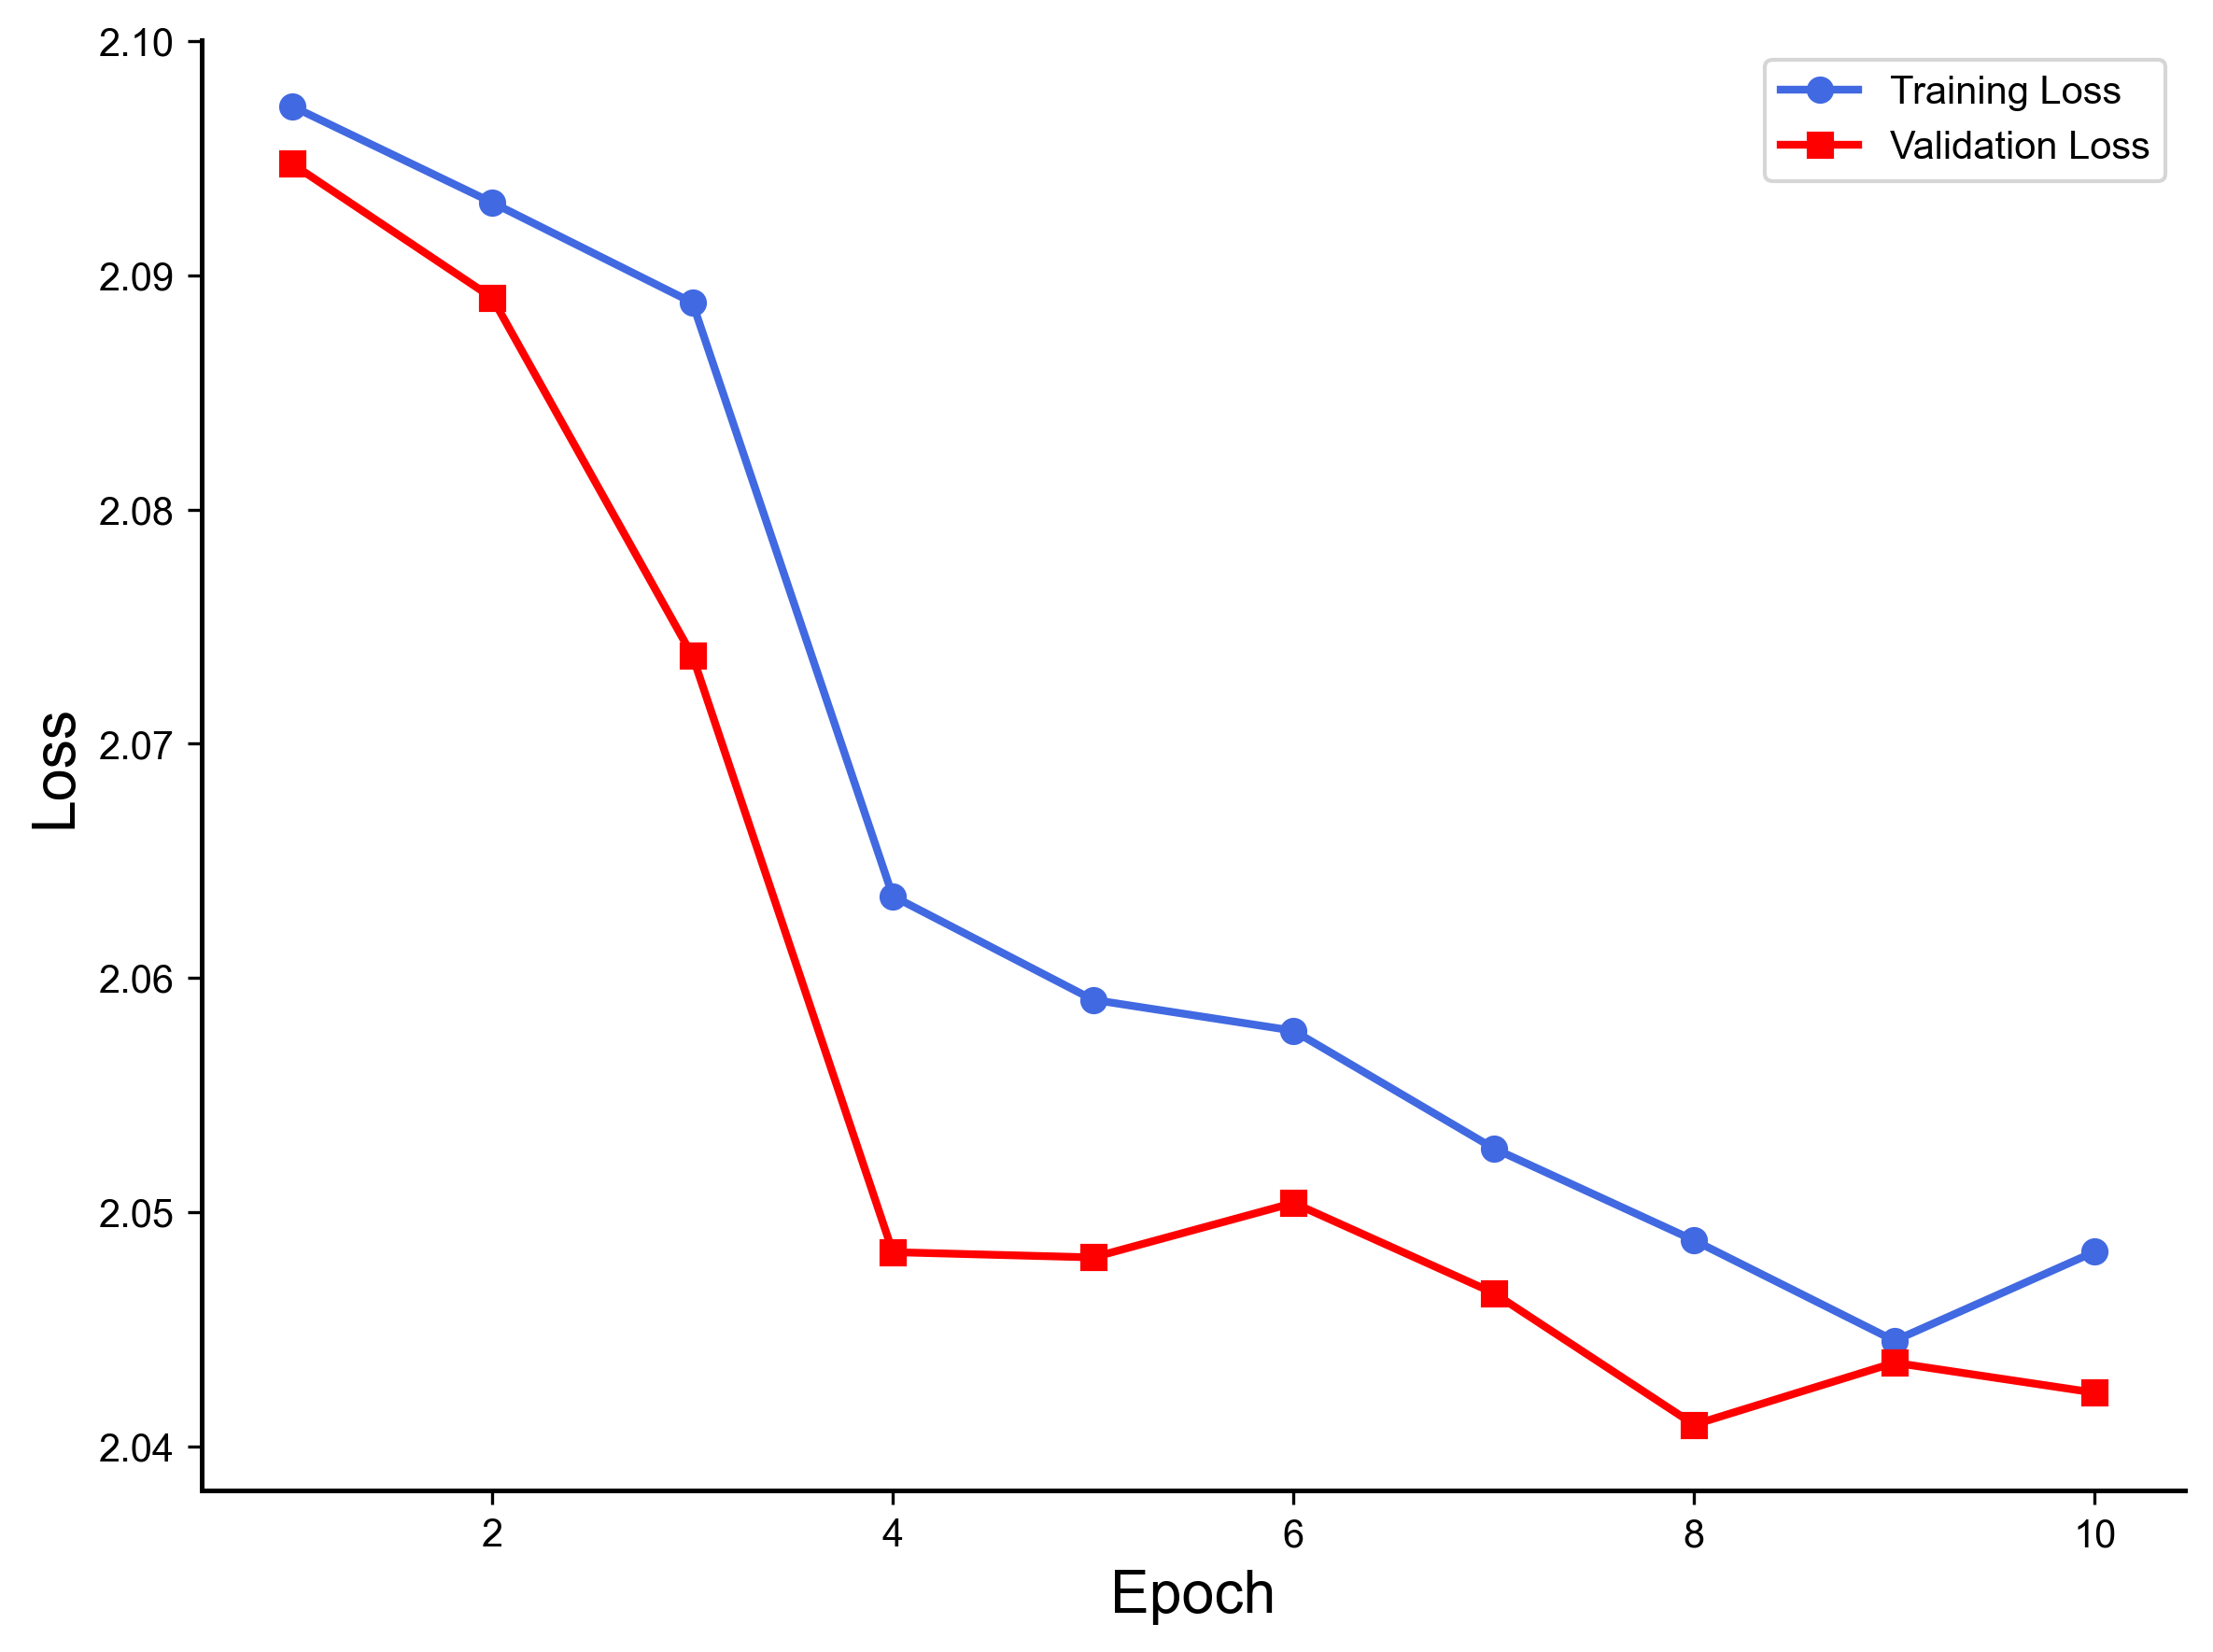

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# Configuration (matching your publication style)
FIGURE_SIZE = (8, 6)
DPI = 300
FONT_SIZE_LABELS = 15
FONT_SIZE_TICKS = 13
FONT_SIZE_LEGEND = 13
SPINE_WIDTH = 1.2

# Colors
COLOR_TRAIN = 'royalblue'
COLOR_VAL = 'red'

def load_arial_font():
    """Load Arial font for publication quality text"""
    try:
        return fm.FontProperties(fname="arial.ttf")
    except:
        print("Warning: Arial font not found. Using default font.")
        return fm.FontProperties()

# Load font
arial_font = load_arial_font()

# Create figure
fig, ax = plt.subplots(figsize=FIGURE_SIZE, dpi=DPI)

# Plot epoch losses
epochs = np.arange(1, len(training_losses) + 1)
ax.plot(
    epochs, training_losses,
    color=COLOR_TRAIN,
    linewidth=2,
    marker='o',
    markersize=6,
    label='Training Loss',
    zorder=3
)

# Plot validation losses
ax.plot(
    epochs, validation_losses,
    color=COLOR_VAL,
    linewidth=2,
    marker='s',
    markersize=6,
    label='Validation Loss',
    zorder=3
)

# Axis labels
ax.set_xlabel(
    'Epoch',
    fontsize=FONT_SIZE_LABELS,
    fontproperties=arial_font,
    fontweight='normal'
)
ax.set_ylabel(
    'Loss',
    fontsize=FONT_SIZE_LABELS,
    fontproperties=arial_font,
    fontweight='normal'
)

# Tick formatting
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(arial_font)

# Spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(SPINE_WIDTH)
    ax.spines[spine].set_color('black')

# Legend
ax.legend(
    fontsize=FONT_SIZE_LEGEND,
    prop=arial_font,
    frameon=True,
    loc='best'
)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig('training_progress_150M.svg', dpi=DPI, format='svg', bbox_inches='tight')

print("Figures saved:")
print
plt.show()

# Evaluate Model

In [ ]:
print("Loading fine-tuned model for inference...")

# Load the fine-tuned weights
model_path = 'finetuned_esm_150M_husc.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    print(f"Model loaded successfully from {model_path}")
else:
    print(f"Warning: Model file not found at {model_path}")
    print("Using base model without fine-tuning")

model.to(device)

Loading fine-tuned model for inference...
Model loaded successfully from finetuned_esm_150M_husc.pth


PeftModelForFeatureExtraction(
  (base_model): LoraModel(
    (model): EsmForMaskedLM(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 640, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-29): 30 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=640, out_features=640, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=640, out_features=8, bias=False)
                    )
                    (lora_B): ModuleDict(
                      (default): Linear(in_features=8, out_features=640, bias=False)
             

In [ ]:
def get_LLR_scores(input_ids, model, device, seq_list):
    """
    Calculate log-likelihood ratio (LLR) scores for all possible amino acid substitutions.

    Args:
        input_ids: Tokenized sequence
        model: Fine-tuned ESM model
        device: Computing device
        seq_list: List of amino acids in the sequence

    Returns:
        DataFrame with LLR scores (rows: alternative AAs, columns: positions)
    """
    with torch.no_grad():
        # Forward pass through the model
        results = model(input_ids.to(device))
        logits = results.logits

        # Compute log softmax
        log_softmax_results = torch.log_softmax(logits, dim=-1)

        # Extract logits, removing special tokens
        WTlogits = log_softmax_results[:, 1:-1, :].squeeze(0)

        # Create DataFrame with amino acid logits
        WTlogits_df = pd.DataFrame(
            WTlogits[:, 4:24].cpu().numpy(),  # Extract AA logits (tokens 4-23)
            columns=AMINO_ACIDS,
            index=[f"{aa} {i+1}" for i, aa in enumerate(seq_list)]
        ).T

        # Compute normalization (wild-type logits on diagonal)
        wt_norm = np.diag(WTlogits_df.loc[[i.split(' ')[0] for i in WTlogits_df.columns]])

        # Compute LLR scores (subtract WT from all alternatives)
        LLR = WTlogits_df - wt_norm

        return LLR

print("Inference function defined successfully")

Inference function defined successfully


In [ ]:
# ProteinGym data paths (update these to your Google Drive paths)
DMS_SUMMARY = 'DMS_substitutions.csv'
OUTPUT_DIR = '/ProteinGym_predictions_150M'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if summary file exists
if os.path.exists(DMS_SUMMARY):
    summary_df = pd.read_csv(DMS_SUMMARY, header=0)
    print(f"Loaded {len(summary_df)} sequences from ProteinGym summary")
    print(f"Output will be saved to: {OUTPUT_DIR}")
else:
    print(f"Warning: DMS summary file not found at {DMS_SUMMARY}")
    print("Please update the path or upload the file")

Loaded 217 sequences from ProteinGym summary
Output will be saved to: /ProteinGym_predictions_150M


In [ ]:
import numpy as np
# Process each sequence in the summary DataFrame
successful_predictions = 0
skipped_sequences = 0

for idx, row in tqdm(summary_df.iterrows(), total=len(summary_df), desc="Processing sequences"):
    seq_len = int(row['seq_len'])

    # Skip sequences longer than model max length
    if seq_len > 1022:
        print(f"Skipping {row['DMS_id']}: sequence too long ({seq_len} > 1022)")
        skipped_sequences += 1
        continue

    filename = row['DMS_id']
    sequence = row['target_seq']
    seq_list = list(sequence)

    try:
        # Tokenize the sequence
        tokenized = tokenizer(
            sequence,
            padding=False,
            truncation=True,
            max_length=1022,
            return_tensors='pt'
        )
        input_ids = tokenized['input_ids']

        # Calculate LLR scores
        LLR = get_LLR_scores(input_ids, model, device, seq_list)

        # Save LLR scores to CSV
        output_path = os.path.join(OUTPUT_DIR, f'{filename}_LLR.csv')
        LLR.to_csv(output_path, index=True)

        successful_predictions += 1

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

print(f"\n{'='*60}")
print(f"Inference completed!")
print(f"Successfully processed: {successful_predictions}")
print(f"Skipped (too long): {skipped_sequences}")
print(f"Failed: {len(summary_df) - successful_predictions - skipped_sequences}")
print(f"Results saved to: {OUTPUT_DIR}")
print(f"{'='*60}")

Processing sequences:   0%|          | 0/217 [00:00<?, ?it/s]

Skipping A0A140D2T1_ZIKV_Sourisseau_2019: sequence too long (3423 > 1022)


Processing sequences:  13%|█▎        | 28/217 [00:02<00:10, 18.01it/s]

Skipping BRCA1_HUMAN_Findlay_2018: sequence too long (1863 > 1022)
Skipping BRCA2_HUMAN_Erwood_2022_HEK293T: sequence too long (3418 > 1022)


Processing sequences:  15%|█▌        | 33/217 [00:02<00:08, 22.50it/s]

Skipping CAR11_HUMAN_Meitlis_2020_gof: sequence too long (1154 > 1022)
Skipping CAR11_HUMAN_Meitlis_2020_lof: sequence too long (1154 > 1022)
Skipping CAS9_STRP1_Spencer_2017_positive: sequence too long (1368 > 1022)


Processing sequences:  29%|██▊       | 62/217 [00:04<00:09, 16.14it/s]

Skipping ERBB2_HUMAN_Elazar_2016: sequence too long (1255 > 1022)


Processing sequences:  41%|████      | 89/217 [00:06<00:08, 15.99it/s]

Skipping KCNH2_HUMAN_Kozek_2020: sequence too long (1159 > 1022)


Processing sequences:  49%|████▉     | 107/217 [00:07<00:06, 17.55it/s]

Skipping NPC1_HUMAN_Erwood_2022_HEK293T: sequence too long (1278 > 1022)
Skipping NPC1_HUMAN_Erwood_2022_RPE1: sequence too long (1278 > 1022)


Processing sequences:  60%|█████▉    | 130/217 [00:09<00:05, 15.81it/s]

Skipping POLG_CXB3N_Mattenberger_2021: sequence too long (2185 > 1022)
Skipping POLG_HCVJF_Qi_2014: sequence too long (3033 > 1022)


Processing sequences:  82%|████████▏ | 178/217 [00:12<00:02, 16.57it/s]

Skipping SCN5A_HUMAN_Glazer_2019: sequence too long (2016 > 1022)


Processing sequences:  87%|████████▋ | 188/217 [00:12<00:01, 19.71it/s]

Skipping SPIKE_SARS2_Starr_2020_binding: sequence too long (1273 > 1022)
Skipping SPIKE_SARS2_Starr_2020_expression: sequence too long (1273 > 1022)


Processing sequences:  97%|█████████▋| 211/217 [00:14<00:00, 16.65it/s]

Skipping UBE4B_MOUSE_Starita_2013: sequence too long (1173 > 1022)


Processing sequences: 100%|██████████| 217/217 [00:14<00:00, 14.61it/s]


Inference completed!
Successfully processed: 201
Skipped (too long): 16
Failed: 0
Results saved to: /ProteinGym_predictions_150M


In [ ]:
import re

# Paths for DMS data and LLR predictions
DMS_DIR = 'DMS'  # Update to your path
LLR_PATH = '/ProteinGym_predictions_150M'  # Use the output from inference

print(f"DMS directory: {DMS_DIR}")
print(f"LLR predictions directory: {LLR_PATH}")

# Check if directories exist
if os.path.exists(DMS_DIR):
    dms_files = [f for f in os.listdir(DMS_DIR) if f.endswith('.csv')]
    print(f"Found {len(dms_files)} DMS files")
else:
    print(f"Warning: DMS directory not found at {DMS_DIR}")

if os.path.exists(LLR_PATH):
    llr_files = [f for f in os.listdir(LLR_PATH) if f.endswith('_LLR.csv')]
    print(f"Found {len(llr_files)} LLR prediction files")
else:
    print(f"Warning: LLR directory not found at {LLR_PATH}")

DMS directory: DMS
LLR predictions directory: /ProteinGym_predictions_150M
Found 217 DMS files
Found 201 LLR prediction files


In [ ]:
# Process each DMS file and add model scores
processed_count = 0
skipped_count = 0
error_count = 0

for file in tqdm(os.listdir(DMS_DIR), desc="Scoring DMS variants"):
    # Skip non-CSV files
    if not file.endswith('.csv'):
        continue

    file_path = os.path.join(DMS_DIR, file)
    name = os.path.splitext(file)[0]
    LLR_file_name = f'{name}_LLR.csv'
    llr_file_path = os.path.join(LLR_PATH, LLR_file_name)

    # Check if both files exist
    if not os.path.exists(llr_file_path):
        print(f"Skipping {name}: No LLR predictions found")
        skipped_count += 1
        continue

    try:
        # Load DMS data
        dms_df = pd.read_csv(file_path, header=0)
        dms_df['HuSC_ESM150M'] = None  # Column name for your model scores

        # Load LLR predictions
        llr_df = pd.read_csv(llr_file_path, header=0, index_col=0)

        # Score each variant
        for idx, row in dms_df.iterrows():
            mutants = row['mutant'].split(':')  # Split multiple mutations
            scores = []

            for mutant in mutants:
                # Parse mutation string (e.g., "A123V")
                match = re.match(r"([A-Za-z]+)(\d+)([A-Za-z]+)", mutant)
                if match:
                    wt_aa = match.group(1)      # Wild-type amino acid
                    position = match.group(2)   # Position
                    mut_aa = match.group(3)     # Mutant amino acid

                    try:
                        # Get LLR score for this substitution
                        score = float(llr_df.at[mut_aa, f'{wt_aa} {position}'])
                        scores.append(score)
                    except KeyError:
                        # Score not found for this mutation
                        continue

            # Calculate average score for multiple mutations
            if scores:
                avg_score = sum(scores) / len(scores)
            else:
                avg_score = None

            # Update dataframe
            dms_df.at[idx, 'HuSC_ESM150M'] = avg_score

        # Save updated DMS file
        dms_df.to_csv(file_path, index=False)
        processed_count += 1

    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        error_count += 1
        continue

print(f"\n{'='*60}")
print(f"DMS scoring completed!")
print(f"Successfully processed: {processed_count}")
print(f"Skipped (no predictions): {skipped_count}")
print(f"Errors: {error_count}")
print(f"{'='*60}")

Scoring DMS variants:   8%|▊         | 17/221 [02:07<1:41:05, 29.73s/it]

Skipping KCNH2_HUMAN_Kozek_2020: No LLR predictions found
Skipping NPC1_HUMAN_Erwood_2022_RPE1: No LLR predictions found
Skipping ERBB2_HUMAN_Elazar_2016: No LLR predictions found
Skipping SCN5A_HUMAN_Glazer_2019: No LLR predictions found
Skipping BRCA2_HUMAN_Erwood_2022_HEK293T: No LLR predictions found
Skipping NPC1_HUMAN_Erwood_2022_HEK293T: No LLR predictions found
Skipping UBE4B_MOUSE_Starita_2013: No LLR predictions found
Skipping CAR11_HUMAN_Meitlis_2020_gof: No LLR predictions found
Skipping CAR11_HUMAN_Meitlis_2020_lof: No LLR predictions found
Skipping BRCA1_HUMAN_Findlay_2018: No LLR predictions found
Skipping POLG_HCVJF_Qi_2014: No LLR predictions found
Skipping SPIKE_SARS2_Starr_2020_binding: No LLR predictions found
Skipping SPIKE_SARS2_Starr_2020_expression: No LLR predictions found
Skipping CAS9_STRP1_Spencer_2017_positive: No LLR predictions found
Skipping A0A140D2T1_ZIKV_Sourisseau_2019: No LLR predictions found
Skipping POLG_CXB3N_Mattenberger_2021: No LLR prediction

Scoring DMS variants: 100%|██████████| 221/221 [08:42<00:00,  2.37s/it]


DMS scoring completed!
Successfully processed: 201
Skipped (no predictions): 16
Errors: 0


In [ ]:
# Paths for correlation analysis
DMS_DIR_ANALYSIS = DMS_DIR  # Reuse the DMS directory from earlier
OUTPUT_RESULTS_DIR = '/correlation_results_150M'
os.makedirs(OUTPUT_RESULTS_DIR, exist_ok=True)

OUTPUT_CSV_PATH = os.path.join(OUTPUT_RESULTS_DIR, 'correlation_results_HuSC_ESM.csv')
OUTPUT_PLOT_PATH = os.path.join(OUTPUT_RESULTS_DIR, 'correlation_plot_HuSC_ESM.png')

print(f"Analysis directory: {OUTPUT_RESULTS_DIR}")
print(f"Results will be saved to:")
print(f"  - CSV: {OUTPUT_CSV_PATH}")
print(f"  - Plot: {OUTPUT_PLOT_PATH}")

Analysis directory: /correlation_results_150M
Results will be saved to:
  - CSV: /correlation_results_150M/correlation_results_HuSC_ESM.csv
  - Plot: /correlation_results_150M/correlation_plot_HuSC_ESM.png


In [ ]:
from scipy.stats import spearmanr

# Lists to hold results
all_dms_scores = []
all_esm_scores = []
files_with_correlation = []
correlation_values = []
num_variants_per_file = []

print("Calculating correlations...")

for file in tqdm(os.listdir(DMS_DIR_ANALYSIS), desc="Processing files"):
    if not file.endswith('.csv'):
        continue

    file_path = os.path.join(DMS_DIR_ANALYSIS, file)

    try:
        # Read the CSV file
        df = pd.read_csv(file_path, header=0)

        # Check if required columns exist
        if 'DMS_score' in df.columns and 'HuSC_ESM150M' in df.columns:
            # Remove rows with NaN values
            clean_df = df[['DMS_score', 'HuSC_ESM150M']].dropna()

            if len(clean_df) < 2:  # Need at least 2 points for correlation
                continue

            # Append data points to lists
            all_dms_scores.extend(clean_df['DMS_score'].tolist())
            all_esm_scores.extend(clean_df['HuSC_ESM150M'].tolist())

            # Calculate Spearman correlation for this file
            correlation, p_value = spearmanr(clean_df['DMS_score'], clean_df['HuSC_ESM150M'])

            files_with_correlation.append(os.path.splitext(file)[0])
            correlation_values.append(correlation)
            num_variants_per_file.append(len(clean_df))

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue

print(f"\nProcessed {len(files_with_correlation)} files with valid correlations")
print(f"Total data points: {len(all_dms_scores)}")

Calculating correlations...


Processing files: 100%|██████████| 221/221 [01:18<00:00,  2.81it/s]


Processed 201 files with valid correlations
Total data points: 2075112


In [ ]:
# Create a DataFrame with file names and correlations
correlation_df = pd.DataFrame({
    'DMS_id': files_with_correlation,
    'Spearman_Correlation': correlation_values,
    'Num_Variants': num_variants_per_file
})

# Sort by correlation (descending)
correlation_df = correlation_df.sort_values('Spearman_Correlation', ascending=False)

# Calculate statistics
if correlation_values:
    avg_correlation = sum(correlation_values) / len(correlation_values)
    median_correlation = correlation_df['Spearman_Correlation'].median()

    print(f"\n{'='*60}")
    print(f"Correlation Statistics:")
    print(f"  Average Spearman: {avg_correlation:.4f}")
    print(f"  Median Spearman: {median_correlation:.4f}")
    print(f"  Min: {min(correlation_values):.4f}")
    print(f"  Max: {max(correlation_values):.4f}")
    print(f"{'='*60}")
else:
    avg_correlation = None
    print("No correlations calculated.")

# Save the correlation results to CSV
correlation_df.to_csv(OUTPUT_CSV_PATH, index=False)
print(f"\nCorrelation results saved to: {OUTPUT_CSV_PATH}")

# Display top and bottom correlations
print("\nTop 10 correlations:")
print(correlation_df.head(10))

print("\nBottom 10 correlations:")
print(correlation_df.tail(10))


Correlation Statistics:
  Average Spearman: 0.4197
  Median Spearman: 0.4678
  Min: -0.2467
  Max: 0.7934

Correlation results saved to: /correlation_results_150M/correlation_results_HuSC_ESM.csv

Top 10 correlations:
                              DMS_id  Spearman_Correlation  Num_Variants
39    RPC1_BP434_Tsuboyama_2023_1R69              0.793434          1459
50   EPHB2_HUMAN_Tsuboyama_2023_1F0M              0.787090          1960
130  SR43C_ARATH_Tsuboyama_2023_2N88              0.768046          1583
189  CBPA2_HUMAN_Tsuboyama_2023_1O6X              0.721906          2068
36    PSAE_SYNP2_Tsuboyama_2023_1PSE              0.715121          1579
14    VG08_BPP22_Tsuboyama_2023_2GP8              0.714062           723
146  TCRG1_MOUSE_Tsuboyama_2023_1E0L              0.707266          1058
131  OBSCN_HUMAN_Tsuboyama_2023_1V1C              0.706534          3197
110  DNJA1_HUMAN_Tsuboyama_2023_2LO1              0.702771          2264
66            A4GRB6_PSEAI_Chen_2020              0

In [ ]:
# Load the ProteinGym scores CSV
proteingym_scores_path = 'proteingym_scores.csv'  # Update path
proteingym_df = pd.read_csv(proteingym_scores_path)

print(f"Original ProteinGym dataframe shape: {proteingym_df.shape}")

proteingym_df = proteingym_df.drop(columns=['ESM_150M_ft'])

# Create DMS_id from DMS_filename by removing .csv
proteingym_df['DMS_id'] = proteingym_df['DMS_filename'].str.replace('.csv', '', regex=False)

# Rename the correlation column before merging
correlation_df_renamed = correlation_df.rename(columns={'Spearman_Correlation': 'ESM_150M_ft'})

# Merge the correlation data
proteingym_df = proteingym_df.merge(
    correlation_df_renamed[['DMS_id', 'ESM_150M_ft']],
    on='DMS_id',
    how='left'  # Keep all rows from proteingym_df
)

# Drop the temporary DMS_id column if you don't need it
# proteingym_df = proteingym_df.drop('DMS_id', axis=1)

print(f"Updated ProteinGym dataframe shape: {proteingym_df.shape}")
print(f"Number of assays with ESM_150M_ft scores: {proteingym_df['ESM_150M_ft'].notna().sum()}")

# Save the updated dataframe
proteingym_df.to_csv(proteingym_scores_path, index=False)
print(f"\nUpdated ProteinGym scores saved to: {proteingym_scores_path}")

# Show sample of the merged data
print("\nSample of merged data:")
print(proteingym_df[['DMS_filename', 'ESM_150M_ft']].head(10))

Original ProteinGym dataframe shape: (201, 85)
Updated ProteinGym dataframe shape: (201, 86)
Number of assays with ESM_150M_ft scores: 201

Updated ProteinGym scores saved to: proteingym_scores.csv

Sample of merged data:
                           DMS_filename  ESM_150M_ft
0      A0A192B1T2_9HIV1_Haddox_2018.csv     0.151709
1   A0A1I9GEU1_NEIME_Kennouche_2019.csv    -0.026894
2  A0A247D711_LISMN_Stadelmann_2021.csv     0.266881
3        A0A2Z5U3Z0_9INFA_Doud_2016.csv     0.142024
4          A0A2Z5U3Z0_9INFA_Wu_2014.csv     0.098274
5               A4_HUMAN_Seuma_2022.csv     0.461256
6             A4D664_9INFA_Soh_2019.csv     0.062676
7            A4GRB6_PSEAI_Chen_2020.csv     0.698258
8          AACC1_PSEAI_Dandage_2018.csv     0.343518
9              ACE2_HUMAN_Chan_2020.csv     0.169804



Performance Breakdown:
Excellent (≥0.7)    :   9 assays (  4.5%)
Good (0.5-0.7)      :  70 assays ( 34.8%)
Moderate (0.3-0.5)  :  72 assays ( 35.8%)
Negative (<0)       :   8 assays (  4.0%)
Weak (0-0.3)        :  42 assays ( 20.9%)


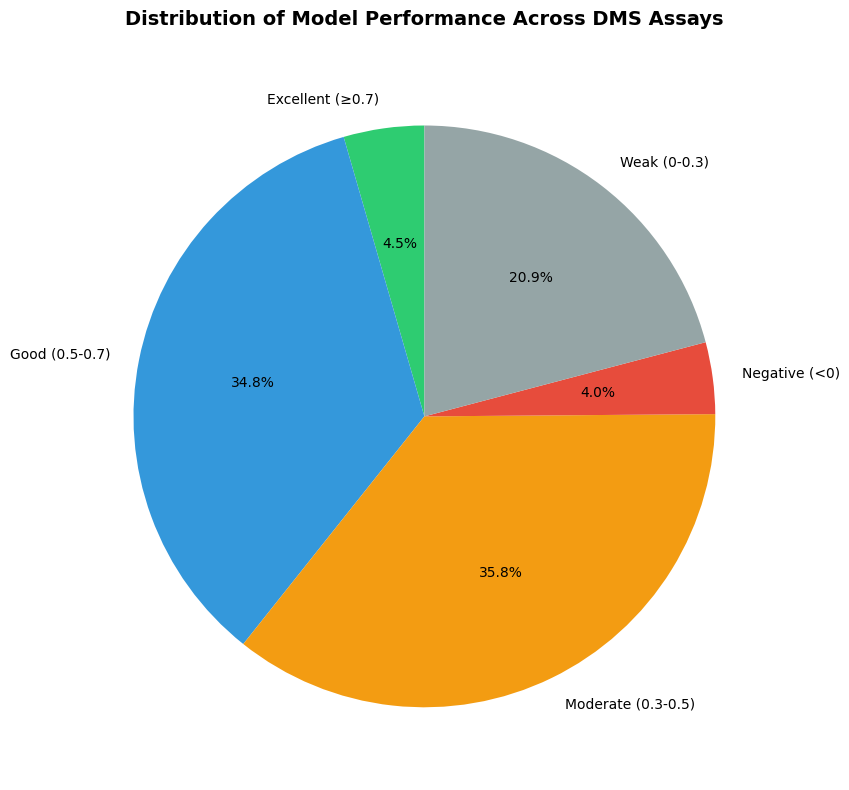

In [ ]:
import matplotlib.pyplot as plt


# Performance breakdown by correlation ranges
def categorize_correlation(corr):
    if corr >= 0.7:
        return 'Excellent (≥0.7)'
    elif corr >= 0.5:
        return 'Good (0.5-0.7)'
    elif corr >= 0.3:
        return 'Moderate (0.3-0.5)'
    elif corr >= 0:
        return 'Weak (0-0.3)'
    else:
        return 'Negative (<0)'

correlation_df['Performance'] = correlation_df['Spearman_Correlation'].apply(categorize_correlation)

# Count by category
performance_summary = correlation_df['Performance'].value_counts().sort_index()

print("\nPerformance Breakdown:")
print("="*60)
for category, count in performance_summary.items():
    percentage = 100 * count / len(correlation_df)
    print(f"{category:20s}: {count:3d} assays ({percentage:5.1f}%)")
print("="*60)

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#95a5a6']
ax.pie(performance_summary.values, labels=performance_summary.index, autopct='%1.1f%%',
       startangle=90, colors=colors[:len(performance_summary)])
ax.set_title('Distribution of Model Performance Across DMS Assays',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_RESULTS_DIR, 'performance_breakdown.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Calculate NLL

In [ ]:
output_dir = "ESM_150M_NLL_ft"
os.makedirs(output_dir, exist_ok=True)

# Iterate over CSVs
for filename in os.listdir(LLR_PATH):
    if filename.endswith(".csv"):
        filepath = os.path.join(LLR_PATH, filename)
        df = pd.read_csv(filepath, header=0)

        # Extract positions and wild-type amino acids from column names
        # Columns like "M 1", "E 2", etc.
        wt_info = [col.split() for col in df.columns[1:]]  # skip first column (mutant AAs)
        wt_aas = [x[0] for x in wt_info]
        positions = [int(x[1]) for x in wt_info]

        # Mutant amino acids from the first column
        mutant_aas = df.iloc[:, 0].tolist()
        mutant_to_idx = {aa: i for i, aa in enumerate(mutant_aas)}

        # LLR matrix (mutants x positions)
        llr_matrix = df.iloc[:, 1:].values.astype(float)

        nlls = []

        # Calculate NLL for each position
        for i, wt_aa in enumerate(wt_aas):
            # Indices of all mutants excluding the WT at this position
            mutant_indices = [idx for aa, idx in mutant_to_idx.items() if aa != wt_aa]
            # LLRs of mutants at this position
            llrs = llr_matrix[mutant_indices, i]
            # NLL for this position
            nll = np.log(1 + np.sum(np.exp(llrs)))
            nlls.append(nll)

        # Save output CSV
        out_df = pd.DataFrame({
            "wt_aa": wt_aas,
            "position": positions,
            "nll": nlls
        })

        out_path = os.path.join(output_dir, filename)
        out_df.to_csv(out_path, index=False)
        print(f"Processed {filename} → {out_path}")


Processed S22A1_HUMAN_Yee_2023_activity_LLR.csv → ESM_150M_NLL_ft/S22A1_HUMAN_Yee_2023_activity_LLR.csv
Processed CATR_CHLRE_Tsuboyama_2023_2AMI_LLR.csv → ESM_150M_NLL_ft/CATR_CHLRE_Tsuboyama_2023_2AMI_LLR.csv
Processed CALM1_HUMAN_Weile_2017_LLR.csv → ESM_150M_NLL_ft/CALM1_HUMAN_Weile_2017_LLR.csv
Processed A4GRB6_PSEAI_Chen_2020_LLR.csv → ESM_150M_NLL_ft/A4GRB6_PSEAI_Chen_2020_LLR.csv
Processed Q6WV13_9MAXI_Somermeyer_2022_LLR.csv → ESM_150M_NLL_ft/Q6WV13_9MAXI_Somermeyer_2022_LLR.csv
Processed BLAT_ECOLX_Firnberg_2014_LLR.csv → ESM_150M_NLL_ft/BLAT_ECOLX_Firnberg_2014_LLR.csv
Processed B2L11_HUMAN_Dutta_2010_binding-Mcl-1_LLR.csv → ESM_150M_NLL_ft/B2L11_HUMAN_Dutta_2010_binding-Mcl-1_LLR.csv
Processed RS15_GEOSE_Tsuboyama_2023_1A32_LLR.csv → ESM_150M_NLL_ft/RS15_GEOSE_Tsuboyama_2023_1A32_LLR.csv
Processed A0A2Z5U3Z0_9INFA_Doud_2016_LLR.csv → ESM_150M_NLL_ft/A0A2Z5U3Z0_9INFA_Doud_2016_LLR.csv
Processed AICDA_HUMAN_Gajula_2014_3cycles_LLR.csv → ESM_150M_NLL_ft/AICDA_HUMAN_Gajula_2014_

In [ ]:
import os
import pandas as pd
import numpy as np

# ========================
# CONFIG
# ========================
proteingym_scores_path = "proteingym_scores.csv"
NLL_DIR = "ESM_150M_NLL_ft"
NLL_COL = "nll"
OUT_COL = "NLL_150M_ft"

# ========================
# LOAD PROTEINGYM
# ========================
proteingym_df = pd.read_csv(proteingym_scores_path)

print(f"Loaded ProteinGym CSV: {proteingym_df.shape}")

# Ensure column exists (overwrite behavior)
proteingym_df[OUT_COL] = np.nan

# ========================
# ITERATE OVER ASSAYS
# ========================
found = 0
missing = 0

for idx, row in proteingym_df.iterrows():
    dms_filename = row["DMS_filename"]  # e.g. ABC123.csv

    if not dms_filename.endswith(".csv"):
        missing += 1
        continue

    # Convert to *_LLR.csv
    llr_filename = dms_filename.replace(".csv", "_LLR.csv")
    llr_path = os.path.join(NLL_DIR, llr_filename)

    if not os.path.exists(llr_path):
        missing += 1
        continue

    # Load NLL file and compute average
    nll_df = pd.read_csv(llr_path)

    if NLL_COL not in nll_df.columns or nll_df.empty:
        missing += 1
        continue

    avg_nll = nll_df[NLL_COL].mean()

    proteingym_df.at[idx, OUT_COL] = avg_nll
    found += 1

print(f"Avg NLL computed for {found} assays")
print(f"Missing / skipped assays: {missing}")

# ========================
# SAVE
# ========================
proteingym_df.to_csv(proteingym_scores_path, index=False)
print(f"Updated ProteinGym CSV saved → {proteingym_scores_path}")

# ========================
# SANITY CHECK
# ========================
print(
    proteingym_df[
        ["DMS_filename", OUT_COL]
    ].head(10)
)


Loaded ProteinGym CSV: (201, 85)
Avg NLL computed for 201 assays
Missing / skipped assays: 0
Updated ProteinGym CSV saved → proteingym_scores.csv
                           DMS_filename  NLL_150M_ft
0      A0A192B1T2_9HIV1_Haddox_2018.csv     1.404833
1   A0A1I9GEU1_NEIME_Kennouche_2019.csv     0.762753
2  A0A247D711_LISMN_Stadelmann_2021.csv     0.922407
3        A0A2Z5U3Z0_9INFA_Doud_2016.csv     1.353878
4          A0A2Z5U3Z0_9INFA_Wu_2014.csv     1.353878
5               A4_HUMAN_Seuma_2022.csv     1.608311
6             A4D664_9INFA_Soh_2019.csv     1.125603
7            A4GRB6_PSEAI_Chen_2020.csv     0.521921
8          AACC1_PSEAI_Dandage_2018.csv     0.711964
9              ACE2_HUMAN_Chan_2020.csv     0.858283


# Calculate NDCG @ top 10%

In [ ]:
import os
import numpy as np
import pandas as pd

# ========================
# CONFIG
# ========================
DMS_DIR = "DMS"
proteingym_scores_path = "proteingym_scores.csv"
OUT_COL = "NDCG_150M_ft"

# ========================
# NDCG FUNCTION
# ========================
def ndcg_at_k(relevance, scores, k):
    order = np.argsort(scores)[::-1]
    rel_sorted = relevance[order][:k]

    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(rel_sorted / discounts)

    ideal_rel = np.sort(relevance)[::-1][:k]
    idcg = np.sum(ideal_rel / discounts)

    return dcg / idcg if idcg > 0 else np.nan

# ========================
# LOAD PROTEINGYM
# ========================
proteingym_df = pd.read_csv(proteingym_scores_path)

print(f"Loaded ProteinGym CSV: {proteingym_df.shape}")

# Overwrite / create column
proteingym_df[OUT_COL] = np.nan

found = 0
missing = 0

# ========================
# ITERATE OVER ASSAYS
# ========================
for idx, row in proteingym_df.iterrows():
    dms_filename = row["DMS_filename"]
    dms_path = os.path.join(DMS_DIR, dms_filename)

    if not os.path.exists(dms_path):
        missing += 1
        continue

    try:
        df = pd.read_csv(dms_path)

        required_cols = ["DMS_score", "HuSC_ESM150M"]
        if not all(col in df.columns for col in required_cols):
            missing += 1
            continue

        # Drop NaNs
        df = df.dropna(subset=required_cols)
        if df.empty:
            missing += 1
            continue

        # True relevance (shifted to ≥ 0)
        rel = df["DMS_score"].to_numpy()
        relevance = rel - rel.min()

        # Model scores
        scores = df["HuSC_ESM150M"].to_numpy()

        # Top 10% cutoff
        k = max(1, int(0.10 * len(df)))

        ndcg = ndcg_at_k(relevance, scores, k)

        if not np.isnan(ndcg):
            proteingym_df.at[idx, OUT_COL] = ndcg
            found += 1
        else:
            missing += 1

    except Exception as e:
        print(f"Error processing {dms_filename}: {e}")
        missing += 1

print(f"NDCG computed for {found} assays")
print(f"Skipped / missing assays: {missing}")

# ========================
# SAVE
# ========================
proteingym_df.to_csv(proteingym_scores_path, index=False)
print(f"Updated ProteinGym CSV saved → {proteingym_scores_path}")

# ========================
# SANITY CHECK
# ========================
print(
    proteingym_df[
        ["DMS_filename", OUT_COL]
    ].head(10)
)


Loaded ProteinGym CSV: (201, 85)
NDCG computed for 201 assays
Skipped / missing assays: 0
Updated ProteinGym CSV saved → proteingym_scores.csv
                           DMS_filename  NDCG_150M_ft
0      A0A192B1T2_9HIV1_Haddox_2018.csv      0.713583
1   A0A1I9GEU1_NEIME_Kennouche_2019.csv      0.733100
2  A0A247D711_LISMN_Stadelmann_2021.csv      0.836149
3        A0A2Z5U3Z0_9INFA_Doud_2016.csv      0.615767
4          A0A2Z5U3Z0_9INFA_Wu_2014.csv      0.130055
5               A4_HUMAN_Seuma_2022.csv      0.704961
6             A4D664_9INFA_Soh_2019.csv      0.222627
7            A4GRB6_PSEAI_Chen_2020.csv      0.830543
8          AACC1_PSEAI_Dandage_2018.csv      0.762522
9              ACE2_HUMAN_Chan_2020.csv      0.652903


# Calculate NDCG at bottom 10%

In [ ]:
DMS_DIR = "DMS"
proteingym_scores_path = "proteingym_scores.csv"
OUT_COL = "NDCG_bottom_150M_ft"

# ========================
# NDCG FUNCTION (unchanged)
# ========================
def ndcg_at_k(relevance, scores, k):
    # Higher scores ranked first
    order = np.argsort(scores)[::-1]
    rel_sorted = relevance[order][:k]

    discounts = np.log2(np.arange(2, k + 2))
    dcg = np.sum(rel_sorted / discounts)

    ideal_rel = np.sort(relevance)[::-1][:k]
    idcg = np.sum(ideal_rel / discounts)

    return dcg / idcg if idcg > 0 else np.nan

# ========================
# LOAD PROTEINGYM
# ========================
proteingym_df = pd.read_csv(proteingym_scores_path)
print(f"Loaded ProteinGym CSV: {proteingym_df.shape}")

proteingym_df[OUT_COL] = np.nan

found = 0
missing = 0

# ========================
# ITERATE OVER ASSAYS
# ========================
for idx, row in proteingym_df.iterrows():
    dms_filename = row["DMS_filename"]
    dms_path = os.path.join(DMS_DIR, dms_filename)

    if not os.path.exists(dms_path):
        missing += 1
        continue

    try:
        df = pd.read_csv(dms_path)

        required_cols = ["DMS_score", "HuSC_ESM150M"]
        if not all(col in df.columns for col in required_cols):
            missing += 1
            continue

        df = df.dropna(subset=required_cols)
        if df.empty:
            missing += 1
            continue

        # --------------------------------
        # ✅ Bottom-10% relevance definition
        # --------------------------------
        rel = df["DMS_score"].to_numpy()
        relevance = rel.max() - rel   # deleterious = high relevance

        # --------------------------------
        # ✅ Rank low model scores first
        # --------------------------------
        scores = -df["HuSC_ESM150M"].to_numpy()

        k = max(1, int(0.10 * len(df)))

        ndcg = ndcg_at_k(relevance, scores, k)

        if not np.isnan(ndcg):
            proteingym_df.at[idx, OUT_COL] = ndcg
            found += 1
        else:
            missing += 1

    except Exception as e:
        print(f"Error processing {dms_filename}: {e}")
        missing += 1

print(f"NDCG computed for {found} assays")
print(f"Skipped / missing assays: {missing}")

# ========================
# SAVE
# ========================
proteingym_df.to_csv(proteingym_scores_path, index=False)
print(f"Updated ProteinGym CSV saved → {proteingym_scores_path}")

# ========================
# SANITY CHECK
# ========================
print(proteingym_df[["DMS_filename", OUT_COL]].head(10))

Loaded ProteinGym CSV: (201, 85)
NDCG computed for 201 assays
Skipped / missing assays: 0
Updated ProteinGym CSV saved → proteingym_scores.csv
                           DMS_filename  NDCG_bottom_150M_ft
0      A0A192B1T2_9HIV1_Haddox_2018.csv             0.730540
1   A0A1I9GEU1_NEIME_Kennouche_2019.csv             0.626761
2  A0A247D711_LISMN_Stadelmann_2021.csv             0.455741
3        A0A2Z5U3Z0_9INFA_Doud_2016.csv             0.762736
4          A0A2Z5U3Z0_9INFA_Wu_2014.csv             0.988639
5               A4_HUMAN_Seuma_2022.csv             0.852222
6             A4D664_9INFA_Soh_2019.csv             0.979900
7            A4GRB6_PSEAI_Chen_2020.csv             0.896723
8          AACC1_PSEAI_Dandage_2018.csv             0.753876
9              ACE2_HUMAN_Chan_2020.csv             0.712644


# Calculate ROC

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# ========================
# CONFIG
# ========================
DMS_DIR = "DMS"
proteingym_scores_path = "proteingym_scores.csv"
OUT_COL = "ROC_150M_ft"

# ========================
# LOAD PROTEINGYM
# ========================
proteingym_df = pd.read_csv(proteingym_scores_path)
print(f"Loaded ProteinGym CSV: {proteingym_df.shape}")

# Overwrite / create column
proteingym_df[OUT_COL] = np.nan

found = 0
skipped = 0

# ========================
# ITERATE OVER ASSAYS
# ========================
for idx, row in proteingym_df.iterrows():
    dms_filename = row["DMS_filename"]
    dms_path = os.path.join(DMS_DIR, dms_filename)

    if not os.path.exists(dms_path):
        skipped += 1
        continue

    try:
        df = pd.read_csv(dms_path)

        required_cols = ["DMS_score_bin", "HuSC_ESM150M"]
        if not all(col in df.columns for col in required_cols):
            skipped += 1
            continue

        # Drop NaNs
        df = df.dropna(subset=required_cols)
        if df.empty:
            skipped += 1
            continue

        y_true = df["DMS_score_bin"]
        y_score = df["HuSC_ESM150M"]

        # ROC AUC requires both classes
        if y_true.nunique() < 2:
            skipped += 1
            continue

        roc_auc = roc_auc_score(y_true, y_score)

        proteingym_df.at[idx, OUT_COL] = roc_auc
        found += 1

    except Exception as e:
        print(f"Error processing {dms_filename}: {e}")
        skipped += 1

print(f"ROC AUC computed for {found} assays")
print(f"Skipped / missing assays: {skipped}")

# ========================
# SAVE
# ========================
proteingym_df.to_csv(proteingym_scores_path, index=False)
print(f"Updated ProteinGym CSV saved → {proteingym_scores_path}")

# ========================
# SANITY CHECK
# ========================
print(
    proteingym_df[
        ["DMS_filename", OUT_COL]
    ].head(10)
)


Loaded ProteinGym CSV: (201, 85)
ROC AUC computed for 201 assays
Skipped / missing assays: 0
Updated ProteinGym CSV saved → proteingym_scores.csv
                           DMS_filename  ROC_150M_ft
0      A0A192B1T2_9HIV1_Haddox_2018.csv     0.577494
1   A0A1I9GEU1_NEIME_Kennouche_2019.csv     0.485074
2  A0A247D711_LISMN_Stadelmann_2021.csv     0.635148
3        A0A2Z5U3Z0_9INFA_Doud_2016.csv     0.579773
4          A0A2Z5U3Z0_9INFA_Wu_2014.csv     0.556830
5               A4_HUMAN_Seuma_2022.csv     0.748567
6             A4D664_9INFA_Soh_2019.csv     0.536874
7            A4GRB6_PSEAI_Chen_2020.csv     0.887133
8          AACC1_PSEAI_Dandage_2018.csv     0.664410
9              ACE2_HUMAN_Chan_2020.csv     0.554768
